# 00_temp_data_exploration

This notebook __explores temperature data__ for Monterrey in order to find interesting facts and relations __for further analysis and dissemination.__

## Import libraries

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/jovyan/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# Correlation calc
import scipy.stats as stats

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [3]:
city = 'Guadalajara'
projected_crs = "EPSG:32613"
res = 10

## Load data

### __Load data__ - Temperature

In [4]:
temp_schema = 'raster_analysis'
temp_table = 'temperature_analysis_hex'

query = f"SELECT * FROM {temp_schema}.{temp_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
temperature_gdf = aup.gdf_from_query(query, geometry_col='geometry')

infs = temperature_gdf.loc[np.isinf(temperature_gdf['temperature_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    temperature_gdf = temperature_gdf.loc[~np.isinf(temperature_gdf['temperature_mean'])].copy()

# Show
print(temperature_gdf.shape)
temperature_gdf.head(2)

(69460, 17)


,hex_id,geometry,res,temperature_mean,temperature_std,temperature_median,temperature_max,temperature_min,temperature_diff,temperature_tend,temperature_2018,temperature_2019,temperature_2020,temperature_2021,temperature_2022,temperature_2023,city
0,8a49aa25da0ffff,"POLYGON ((-103.49509 20.49762, -103.49444 20.4...",10,37.012738,7.749479,36.539062,47.653646,26.520833,21.132813,-0.078613,36.478795,39.562500,37.419922,37.250000,37.508594,35.338778,Guadalajara
1,8a49aa251907fff,"POLYGON ((-103.44732 20.45841, -103.44668 20.4...",10,36.393928,6.932967,35.771552,46.229885,27.080460,19.149425,-0.018391,35.221675,37.832759,36.158405,36.032759,36.735345,36.510972,Guadalajara


### __Load data__ - NDVI

In [5]:
ndvi_schema = 'raster_analysis'
ndvi_table = 'ndvi_analysis_hex'

query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

infs = ndvi_gdf.loc[np.isinf(ndvi_gdf['ndvi_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    ndvi_gdf = ndvi_gdf.loc[~np.isinf(ndvi_gdf['ndvi_mean'])].copy()

# Show
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(69464, 17)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city
0,8a498c944d87fff,"POLYGON ((-103.30412 20.65432, -103.30347 20.6...",10,0.110235,0.025021,0.117947,0.125205,0.100111,0.025094,-0.000966,0.132457,0.132558,0.124401,0.116938,0.076886,0.078173,Guadalajara
1,8a49aa2ee2c7fff,"POLYGON ((-103.37869 20.51113, -103.37804 20.5...",10,0.200522,0.059544,0.184960,0.284272,0.141168,0.143104,-0.000764,0.212070,0.196492,0.239460,0.236712,0.166791,0.151611,Guadalajara


### __Load data__ - NDMI

In [6]:
ndmi_schema = 'raster_analysis'
ndmi_table = 'ndmi_analysis_hex'

query = f"SELECT * FROM {ndmi_schema}.{ndmi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
ndmi_gdf = aup.gdf_from_query(query, geometry_col='geometry')

infs = ndmi_gdf.loc[np.isinf(ndmi_gdf['ndmi_mean'])]
if len(infs)>0:
    print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
    ndmi_gdf = ndmi_gdf.loc[~np.isinf(ndmi_gdf['ndmi_mean'])].copy()

# Show
print(ndmi_gdf.shape)
ndmi_gdf.head(2)

(69464, 17)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndmi_2018,ndmi_2019,ndmi_2020,ndmi_2021,ndmi_2022,ndmi_2023,city
0,8a498c931c4ffff,"POLYGON ((-103.14431 20.54930, -103.14366 20.5...",10,0.146068,0.046356,0.134942,0.221526,0.098637,0.122889,-0.000715,0.186636,0.134963,0.154567,0.163037,0.122313,0.114888,Guadalajara
1,8a498c94004ffff,"POLYGON ((-103.31411 20.69047, -103.31346 20.6...",10,-0.073017,0.017412,-0.073614,-0.055383,-0.089453,0.034070,0.000554,-0.081233,-0.078369,-0.083390,-0.085738,-0.059837,-0.049533,Guadalajara


### __Load data__ - NDMI for zones with vegetation only

In [7]:
# Create vegetation categories
ndvi_gdf['ndvi_median_range'] = np.nan
ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_range'] = 'Alta densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
             (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_range'] = 'Moderada densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
             (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_range'] = 'Mínima densidad vegetal'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
             (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_range'] = 'Suelo'
ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_range'] = 'Suelo artificial/Agua/Piedra'

# Order data
categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
ndvi_gdf['ndvi_median_range'] = pd.Categorical(ndvi_gdf['ndvi_median_range'], categories=categories, ordered=True)

# Show
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(69464, 18)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndvi_2018,ndvi_2019,ndvi_2020,ndvi_2021,ndvi_2022,ndvi_2023,city,ndvi_median_range
0,8a498c944d87fff,"POLYGON ((-103.30412 20.65432, -103.30347 20.6...",10,0.110235,0.025021,0.117947,0.125205,0.100111,0.025094,-0.000966,0.132457,0.132558,0.124401,0.116938,0.076886,0.078173,Guadalajara,Suelo
1,8a49aa2ee2c7fff,"POLYGON ((-103.37869 20.51113, -103.37804 20.5...",10,0.200522,0.059544,0.184960,0.284272,0.141168,0.143104,-0.000764,0.212070,0.196492,0.239460,0.236712,0.166791,0.151611,Guadalajara,Suelo


In [8]:
# Find hex_ids with vegetation
veg_categories = ['Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
hexs_with_veg = list(ndvi_gdf.loc[ndvi_gdf.ndvi_median_range.isin(veg_categories)].hex_id.unique())
print(f"Hexs with vegetation: {len(hexs_with_veg)} out of {len(ndvi_gdf)}.")

# Filter NDMI data
ndmi_veg_gdf = ndmi_gdf.loc[ndmi_gdf.hex_id.isin(hexs_with_veg)].copy()

# Show
print(ndmi_veg_gdf.shape)
ndmi_veg_gdf.head(2)

Hexs with vegetation: 44818 out of 69464.
(44818, 17)


,hex_id,geometry,res,ndmi_mean,ndmi_std,ndmi_median,ndmi_max,ndmi_min,ndmi_diff,ndmi_tend,ndmi_2018,ndmi_2019,ndmi_2020,ndmi_2021,ndmi_2022,ndmi_2023,city
0,8a498c931c4ffff,"POLYGON ((-103.14431 20.54930, -103.14366 20.5...",10,0.146068,0.046356,0.134942,0.221526,0.098637,0.122889,-0.000715,0.186636,0.134963,0.154567,0.163037,0.122313,0.114888,Guadalajara
3,8a498c95dc77fff,"POLYGON ((-103.30211 20.72872, -103.30147 20.7...",10,-0.027665,0.165243,-0.109716,0.273286,-0.179629,0.452915,0.000329,-0.001873,-0.082344,-0.018786,-0.010030,-0.026119,-0.026836,Guadalajara


### __Load data__ - Marginalization

In [9]:
marg_schema = 'sociodemografico'
marg_table = 'margurb_inegi_20_ageb_hex'

# There's no marg data available for res 10, load res 8 or 9 if required.
if (res==8) or (res==9):
    # Load gdf
    query = f"SELECT * FROM {marg_schema}.{marg_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
    marg_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    # infs check
    infs = marg_gdf.loc[np.isinf(marg_gdf['imn_2020'])]
    if len(infs)>0:
        print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
        marg_gdf = marg_gdf.loc[~np.isinf(marg_gdf['ndmi_mean'])].copy()

# Else, load res 9 and transfer hex9 data to current res hexs by using centroids
elif (res == 10) or (res==11):
    print(f"Marg data res {res} not available. Loading temporary marg_gdf res 9.")
    # Load gdf
    query = f"SELECT * FROM {marg_schema}.{marg_table} WHERE \"city\" = '{city}\' AND \"res\" = '9\'"
    marg_tmp_gdf = aup.gdf_from_query(query, geometry_col='geometry')
    # infs check
    infs = marg_tmp_gdf.loc[np.isinf(marg_tmp_gdf['imn_2020'])]
    if len(infs)>0:
        print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
        marg_tmp_gdf = marg_tmp_gdf.loc[~np.isinf(marg_tmp_gdf['ndmi_mean'])].copy()

    # Create a current-res (10 or 11) hex_gdf
    print(f"Creating res {res} hex_gdf.")
    hex_gdf = ndvi_gdf[['hex_id','res','geometry']].copy()

    # Extract current-res centroids
    print(f"Extracting res {res} centroids.")
    #Find centroids (projected_crs)
    hex_gdf.to_crs(projected_crs,inplace=True)
    centroids_df = pd.DataFrame(hex_gdf.centroid)
    centroids_df.rename(columns={0:'geometry'}, inplace=True)
    #Turn centroids into gdf  (projected_crs)
    centroids_gdf = gpd.GeoDataFrame(centroids_df, geometry='geometry', crs=projected_crs)
    # Convert to EPSG:4326
    centroids_gdf.to_crs("EPSG:4326", inplace=True)
    del centroids_df

    # Intersect centroids with orginal ndvi data to keep hex_id data
    print(f"Saving original res {res} hex_id to centroids.")
    centroids_gdf = gpd.overlay(centroids_gdf, ndvi_gdf, keep_geom_type=True)
    centroids_gdf = centroids_gdf[['hex_id','geometry']]

    # Intersect centroids with marginalization data
    print(f"Transfering to hex res {res} centroids marg res 9 data.")
    marg_gdf = gpd.sjoin(centroids_gdf, marg_tmp_gdf[['imn_2020','geometry']],how='left')
    marg_gdf.drop(columns='index_right', inplace=True)

    # Sustituting centroids geom with hexs geom
    marg_gdf.drop(columns='geometry', inplace=True)
    marg_gdf = pd.merge(marg_gdf, ndvi_gdf[['hex_id','geometry']], on='hex_id')
    marg_gdf = gpd.GeoDataFrame(marg_gdf, geometry='geometry', crs="EPSG:4326")

# Show
print(marg_gdf.crs)
print(marg_gdf.shape)
marg_gdf.head(2)

Marg data res 10 not available. Loading temporary marg_gdf res 9.
Creating res 10 hex_gdf.
Extracting res 10 centroids.
Saving original res 10 hex_id to centroids.
Transfering to hex res 10 centroids marg res 9 data.
epsg:4326
(69464, 3)


,hex_id,imn_2020,geometry
0,8a498c944d87fff,0.955467,"POLYGON ((-103.30412 20.65432, -103.30347 20.6..."
1,8a49aa2ee2c7fff,0.952762,"POLYGON ((-103.37869 20.51113, -103.37804 20.5..."


### __Load data__ - Land Use (Guadalajara, Zapopan)

In [21]:
landuse_gdf = gpd.read_file(str(project_root)+"/data/processed/volvo/uso_de_suelo_guadalajara/predios_uso_suelo.geojson")           

# Show
print(landuse_gdf.crs)
print(landuse_gdf.shape)
landuse_gdf.head(2)

EPSG:32613
(677371, 2)


,clasificacion_uso_suelo,geometry
0,Residencial,"POLYGON ((668816.105 2295371.324, 668811.832 2..."
1,Residencial,"POLYGON ((668729.690 2295298.382, 668723.108 2..."


### __Load data__ - Buildings

In [22]:
a="""
# First time (csv to gpkg)

# Read csv
buildings_df = pd.read_csv(str(project_root)+'/data/external/google_open_buildings/843_buildings.csv')
# Convert to gdf
from shapely.wkt import loads
buildings_df["geometry"] = buildings_df["geometry"].apply(loads)
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry="geometry", crs="EPSG:4326")

# Save
buildings_gdf.to_file(str(project_root)+"/data/external/google_open_buildings/google_buildings_843.gpkg")
"""

In [ ]:
# Read previously created gdf
buildings_gdf = gpd.read_file(str(project_root)+"/data/external/google_open_buildings/google_buildings_843.gpkg")           

# Show
print(buildings_gdf.crs)
print(buildings_gdf.shape)
buildings_gdf.head(2)

## __Analysis 1__ - Tendencia por año de temperatura, NDVI y NDMI

In [10]:
# Temperature data years
temp_data_years = ['temperature_2018', 'temperature_2019', 'temperature_2020', 'temperature_2021', 'temperature_2022', 'temperature_2023']
# Aggregate statistics
temp_stats = temperature_gdf[temp_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
temp_stats.rename(columns={'temperature_2018':'2018',
                           'temperature_2019':'2019',
                           'temperature_2020':'2020',
                           'temperature_2021':'2021',
                           'temperature_2022':'2022',
                           'temperature_2023':'2023'},inplace=True)
# Transpose data
temp_stats_transposed = temp_stats.transpose()
temp_stats_transposed.drop(columns=['std'],inplace=True)

# Show
temp_stats_transposed

,min,mean,median,max
2018,18.337054,34.901786,35.254608,44.899770
2019,16.337500,38.993566,39.064516,50.570000
2020,13.463867,37.768701,38.161290,49.282258
2021,16.906250,36.389568,36.563636,46.903226
2022,18.705469,37.026242,37.459375,49.510484
2023,20.367898,37.776665,38.162642,49.095308


In [11]:
# NDVI data years
ndvi_data_years = ['ndvi_2018', 'ndvi_2019', 'ndvi_2020', 'ndvi_2021', 'ndvi_2022', 'ndvi_2023']
# Aggregate statistics
ndvi_stats = ndvi_gdf[ndvi_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
ndvi_stats.rename(columns={'ndvi_2018':'2018',
                           'ndvi_2019':'2019',
                           'ndvi_2020':'2020',
                           'ndvi_2021':'2021',
                           'ndvi_2022':'2022',
                           'ndvi_2023':'2023'},inplace=True)
# Transpose data
ndvi_stats_transposed = ndvi_stats.transpose()
ndvi_stats_transposed.drop(columns=['std'],inplace=True)

# Show
ndvi_stats_transposed

,min,mean,median,max
2018,-0.275678,0.334358,0.346562,0.852720
2019,-0.222335,0.285347,0.283691,0.803838
2020,-0.128728,0.312346,0.324964,0.873782
2021,-0.275364,0.305133,0.321483,0.823544
2022,-0.085378,0.204787,0.213222,0.632468
2023,-0.051091,0.185584,0.192164,0.603118


In [12]:
# NDMI data years
ndmi_data_years = ['ndmi_2018', 'ndmi_2019', 'ndmi_2020', 'ndmi_2021', 'ndmi_2022', 'ndmi_2023']
# Aggregate statistics
ndmi_stats = ndmi_veg_gdf[ndmi_data_years].agg(['min', 'mean', 'median', 'std', 'max'])
ndmi_stats.rename(columns={'ndmi_2018':'2018',
                           'ndmi_2019':'2019',
                           'ndmi_2020':'2020',
                           'ndmi_2021':'2021',
                           'ndmi_2022':'2022',
                           'ndmi_2023':'2023'},inplace=True)
# Transpose data
ndmi_stats_transposed = ndmi_stats.transpose()
ndmi_stats_transposed.drop(columns=['std'],inplace=True)

# Show
ndmi_stats_transposed

,min,mean,median,max
2018,-0.251182,0.011503,0.000134,0.871496
2019,-0.255746,-0.033818,-0.043137,0.680016
2020,-0.225499,0.005238,-0.007822,0.797963
2021,-0.232442,0.007661,-0.003540,0.794818
2022,-0.165010,0.005795,-0.001473,0.398985
2023,-0.152619,0.002319,-0.004883,0.327519


Text(0, 0.5, 'Mean NDMI')

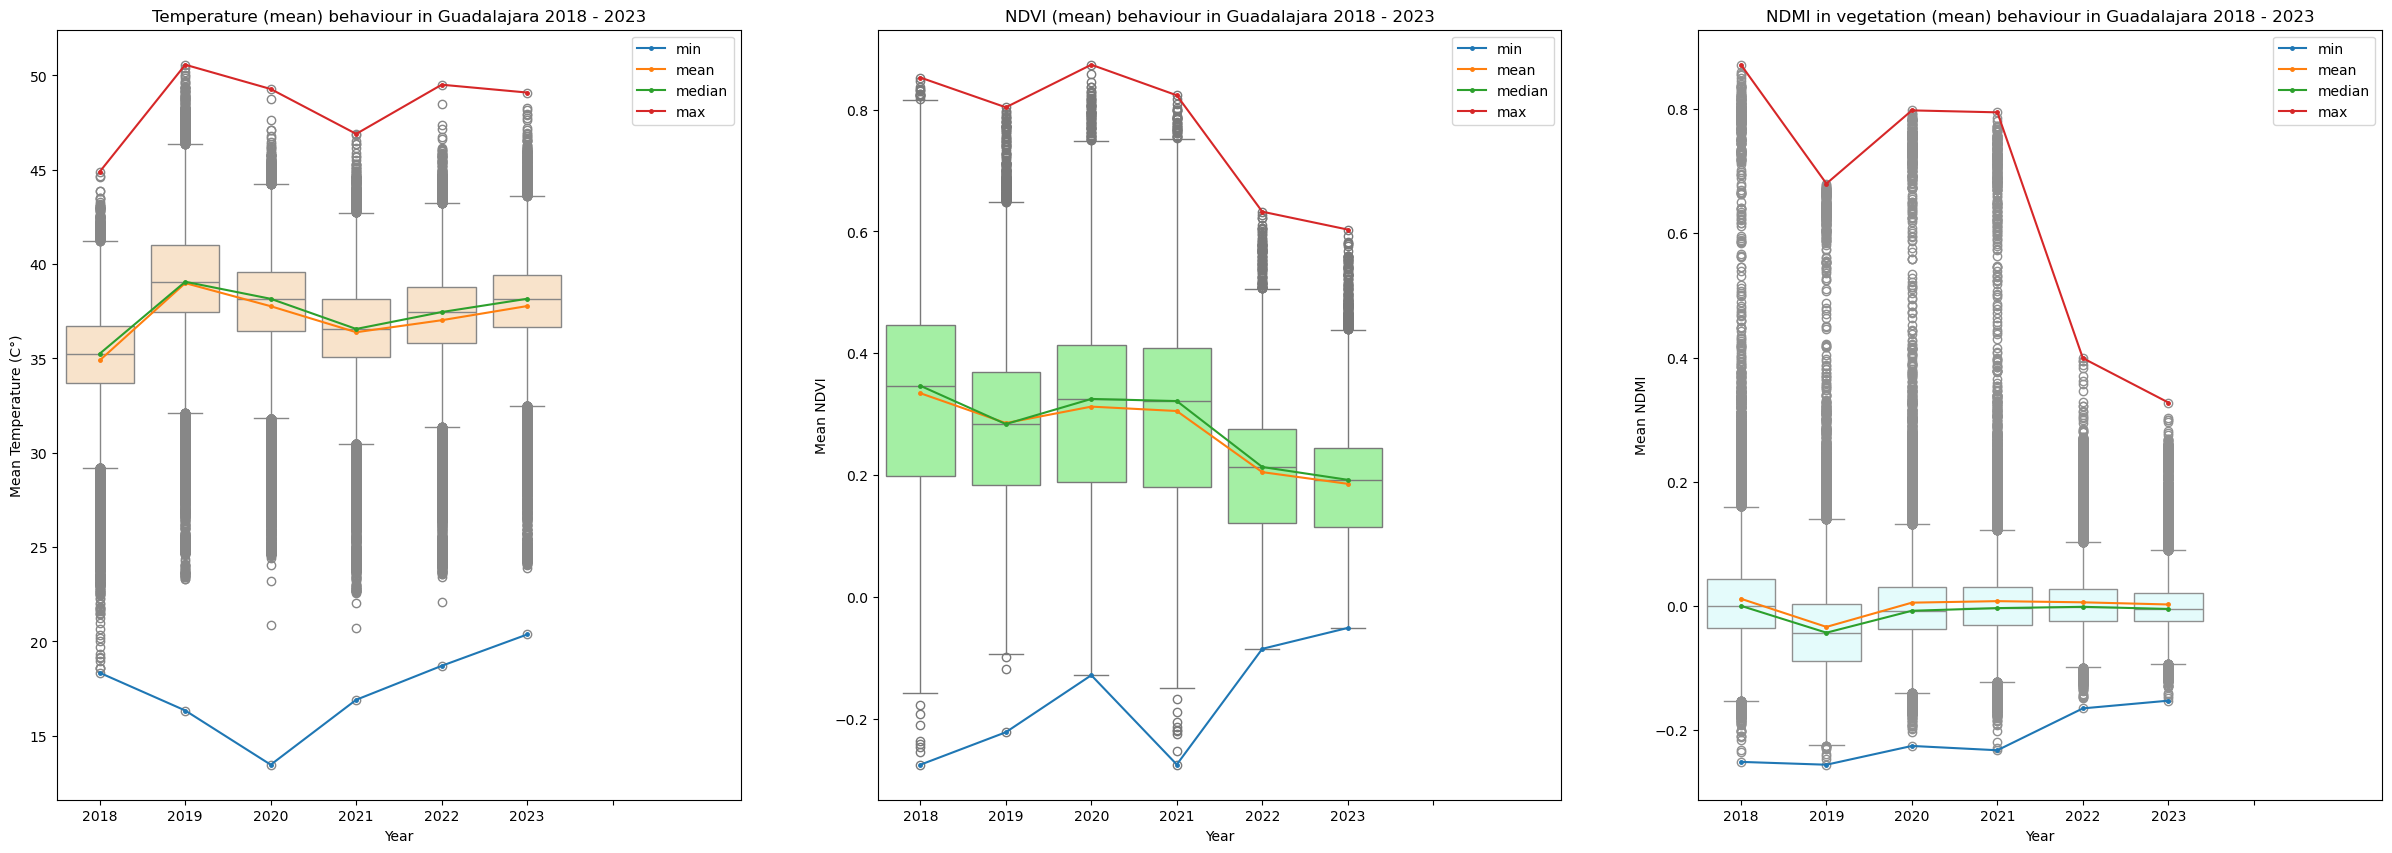

In [15]:
fig, axs = plt.subplots(1,3,figsize=(30,10))

# ---------- Temperature Boxplot data ----------
temperature_yearsummary = pd.DataFrame()
years = ['2018','2019','2020','2021','2022','2023']
for year in years:
    # Extract year's data
    temperature_year = temperature_gdf[[f'temperature_{year}']].copy()
    # Rename column
    temperature_year.rename(columns={f'temperature_{year}':'temperature'},inplace=True)
    # Add year col
    temperature_year['year'] = year
    # Concat
    temperature_yearsummary = pd.concat([temperature_yearsummary,temperature_year])

# ---------- NDVI Boxplot data ----------
ndvi_yearsummary = pd.DataFrame()
years = ['2018','2019','2020','2021','2022','2023']
for year in years:
    # Extract year's data
    ndvi_year = ndvi_gdf[[f'ndvi_{year}']].copy()
    # Rename column
    ndvi_year.rename(columns={f'ndvi_{year}':'ndvi'},inplace=True)
    # Add year col
    ndvi_year['year'] = year
    # Concat
    ndvi_yearsummary = pd.concat([ndvi_yearsummary,ndvi_year])

# ---------- NDMI Boxplot data ----------
ndmi_yearsummary = pd.DataFrame()
years = ['2018','2019','2020','2021','2022','2023']
for year in years:
    # Extract year's data
    ndmi_year = ndmi_veg_gdf[[f'ndmi_{year}']].copy()
    # Rename column
    ndmi_year.rename(columns={f'ndmi_{year}':'ndmi'},inplace=True)
    # Add year col
    ndmi_year['year'] = year
    # Concat
    ndmi_yearsummary = pd.concat([ndmi_yearsummary,ndmi_year])

# ---------- PLOT ----------
temp_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=axs[0],zorder=1)
sns.boxplot(x=np.array(temperature_yearsummary.year), 
            y=np.array(temperature_yearsummary.temperature),
            zorder=0,
            color='bisque',
            ax=axs[0])

# Plot NDVI
ndvi_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=axs[1],zorder=1)
sns.boxplot(x=np.array(ndvi_yearsummary.year), 
            y=np.array(ndvi_yearsummary.ndvi),
            color='palegreen',
            zorder=0,
            ax=axs[1])

# Plot NDMI
ndmi_stats_transposed.plot(style='-o', linewidth = 1.5,markersize=2.5,ax=axs[2],zorder=1)
sns.boxplot(x=np.array(ndmi_yearsummary.year), 
            y=np.array(ndmi_yearsummary.ndmi),
            color='lightcyan',
            zorder=0,
            ax=axs[2])

# ---------- FORMAT ----------
# Format - Main titles
axs[0].set_title(f'Temperature (mean) behaviour in {city} 2018 - 2023')
axs[1].set_title(f'NDVI (mean) behaviour in {city} 2018 - 2023')
axs[2].set_title(f'NDMI in vegetation (mean) behaviour in {city} 2018 - 2023')

# Format - Axis titles
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Mean Temperature (C°)')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Mean NDVI')
axs[2].set_xlabel('Year')
axs[2].set_ylabel('Mean NDMI')

### __Conclusion:__ Needs more data to establish posible tendency, but would be more interesting to see graph by month with overall tendency.

## __Analysis 2__ - Correlations

### __Preparation for correlation analysis:__ Add Temperature anomaly (hex mean - city mean) and NDVI (Mean value)

In [22]:
# Merge temp and ndvi
exploration_gdf_1 = pd.merge(temperature_gdf[['hex_id','temperature_mean','geometry']],ndvi_gdf[['hex_id','ndvi_mean']],on='hex_id')

# Temperature - Calculate anomaly (differential between mean in each hex and city mean)
mean_city_temperature = exploration_gdf_1.temperature_mean.mean()
print(f"Mean temperature in {city}: {mean_city_temperature}.")
exploration_gdf_1['temperature_anomaly'] = exploration_gdf_1['temperature_mean'] - mean_city_temperature
exploration_gdf_1.drop(columns=['temperature_mean'],inplace=True)

# NDVI - Calculate anomaly (differential between mean in each hex and city mean)
#mean_city_ndvi = exploration_gdf_1.ndvi_mean.mean()
#print(f"Mean NDVI in {city}: {mean_city_ndvi}.")
#exploration_gdf_1['ndvi_anomaly'] = exploration_gdf_1['ndvi_mean'] - mean_city_ndvi

# Show
print(exploration_gdf_1.shape)
exploration_gdf_1.head(2)

Mean temperature in Guadalajara: 37.15616344816222.
(69460, 4)


,hex_id,geometry,ndvi_mean,temperature_anomaly
0,8a49aa25da0ffff,"POLYGON ((-103.49509 20.49762, -103.49444 20.4...",0.338912,-0.143426
1,8a49aa251907fff,"POLYGON ((-103.44732 20.45841, -103.44668 20.4...",0.285945,-0.762235


In [42]:
# TWO-VARIABLE CORRELATION GRAPH
a="""
gdf = exploration_gdf_1.copy()
i = 'ndvi_anomaly'
j = 'temperature_anomaly'

fig,ax = plt.subplots()

# Calculate corr
corr, pval = stats.pearsonr(gdf[i],gdf[j])

# Correlation categories
abs_corr = abs(corr)
if abs_corr > 0.80:
    corr_cat = 'Very strong'
    color='darkgreen'
elif (abs_corr<0.80) and (abs_corr>0.60):
    corr_cat = 'Strong'
    color = 'yellowgreen'
elif (abs_corr<0.60) and (abs_corr>0.40):
    corr_cat = 'Moderate'
    color = 'orange'
else:
    corr_cat = 'Weak/very weak'
    color = 'red'

# Plot scatter
ax.scatter(gdf[i], gdf[j], s=5,zorder=0)

# Linear regresion
m, b = np.polyfit(gdf[i], gdf[j], 1)
ax.plot(gdf[i], m*gdf[i] + b, color="red", linestyle="--", label="Trend line",zorder=1)

# Quadratic regresian
coef = np.polyfit(gdf[i], gdf[j], 2) # a*x^2 + b*x + c coeficients
p = np.poly1d(coef) #Helps create curve
# X and Y values based on previous regresion
x_fit = np.linspace(gdf[i].min(), gdf[i].max(), 100) # Rango de X
y_fit = p(x_fit)
# Plot
ax.plot(x_fit, y_fit, color="black", linestyle="--", label="Quadratic trend",zorder=2)

# ---------- FORMAT ----------
# Format - Main title
#plt.title(f"""
#Temperature and NDVI in {city}.
#{corr_cat} corr = {round(corr, 4)}""",fontsize=10,color=color)

# Format - Axis titles
#plt.xlabel("NDVI diferential with city's mean")
#plt.ylabel("Temperature diferential with city's mean (C°)")

### __Preparation for correlation analysis:__ Add NDMI diff

In [43]:
# Add NDMI to exploration_gdf
exploration_gdf_2 = pd.merge(exploration_gdf_1,ndmi_gdf[['hex_id','ndmi_diff']],on='hex_id')

# NDMI - Calculate anomaly (differential between mean in each hex and city mean)
#mean_city_ndmi = exploration_gdf_2.ndmi_mean.mean()
#print(f"Mean NDMI in {city}: {mean_city_ndmi}.")
#exploration_gdf_2['ndmi_anomaly'] = exploration_gdf_2['ndmi_mean'] - mean_city_ndmi

# Show
print(exploration_gdf_2.shape)
exploration_gdf_2.head(2)

(69460, 4)


,hex_id,ndvi_mean,temperature_anomaly,ndmi_diff
0,8a498c972107fff,0.296458,3.285456,0.369276
1,8a498c9467a7fff,0.126603,0.103830,0.041648


### __Preparation for correlation analysis:__ Add Marg.

In [44]:
# Add Marg. to exploration_gdf
#exploration_gdf_3 = pd.merge(exploration_gdf_2,marg_gdf[['hex_id','imn_2020']],on='hex_id')

# Marg. - Calculate anomaly (differential between mean in each hex and city mean)
#mean_city_ndmi = exploration_gdf_3.ndmi_mean.mean()
#print(f"Mean NDMI in {city}: {mean_city_ndmi}.")
#exploration_gdf_2['ndmi_anomaly'] = exploration_gdf_2['ndmi_mean'] - mean_city_ndmi

# Show
#print(exploration_gdf_3.shape)
#exploration_gdf_3.head(2)

In [45]:
exploration_gdf_3 = exploration_gdf_2.copy()

### __Preparation for correlation analysis:__ Add land use

In [23]:
# Isolate hexs
hex_gdf = exploration_gdf_1[['hex_id','temperature_anomaly', 'geometry']].copy()
hex_gdf.head(2)

,hex_id,temperature_anomaly,geometry
0,8a49aa25da0ffff,-0.143426,"POLYGON ((-103.49509 20.49762, -103.49444 20.4..."
1,8a49aa251907fff,-0.762235,"POLYGON ((-103.44732 20.45841, -103.44668 20.4..."


In [29]:
# Assign unique id to each landuse (predio)
if 'unique_id' not in landuse_gdf.columns:
    # Reset index
    landuse_gdf.reset_index(inplace=True,drop=True)
    # Save reseted index to new col
    landuse_gdf.reset_index(inplace=True)
    # Change name
    landuse_gdf.rename(columns={'index':'unique_id'},inplace=True)

# Calculate original landuse area
landuse_gdf['original_area'] = landuse_gdf.area

landuse_gdf.head(2)

,unique_id,clasificacion_uso_suelo,geometry,original_area
0,0,Residencial,"POLYGON ((668816.105 2295371.324, 668811.832 2...",70.089393
1,1,Residencial,"POLYGON ((668729.690 2295298.382, 668723.108 2...",116.458916


In [30]:
# Ensure projected_crs
if hex_gdf.crs != projected_crs:
    hex_gdf.to_crs(projected_crs,inplace=True)
    print(f"Changed hex_gdf crs to {projected_crs}.")    

# Split landuse using the hexs
landuse_split = gpd.overlay(landuse_gdf, hex_gdf, how='intersection')

landuse_split.head(5)

,unique_id,clasificacion_uso_suelo,original_area,hex_id,temperature_anomaly,geometry
0,0,Residencial,70.089393,8a498c949baffff,0.265881,"POLYGON ((668811.832 2295370.843, 668799.907 2..."
1,354,Residencial,51.599512,8a498c949baffff,0.265881,"POLYGON ((668795.276 2295301.078, 668794.795 2..."
2,367,Residencial,51.599646,8a498c949baffff,0.265881,"POLYGON ((668794.795 2295305.351, 668794.315 2..."
3,369,Residencial,51.600084,8a498c949baffff,0.265881,"POLYGON ((668794.315 2295309.624, 668793.835 2..."
4,372,Residencial,51.600535,8a498c949baffff,0.265881,"POLYGON ((668815.316 2295310.366, 668814.815 2..."


In [31]:
landuse_split.loc[landuse_split.unique_id==1]

,unique_id,clasificacion_uso_suelo,original_area,hex_id,temperature_anomaly,geometry
145,1,Residencial,116.458916,8a498c949b17fff,-1.274030,"POLYGON ((668727.507 2295298.137, 668728.667 2..."
153,1,Residencial,116.458916,8a498c949b1ffff,0.010912,"POLYGON ((668723.108 2295297.644, 668719.653 2..."


In [35]:
# Calculate split land use area
landuse_split['split_area'] = landuse_split.area

# Calculate percentage for temperature anomaly distribution
landuse_split['distr_coef'] = landuse_split['split_area']/landuse_split['original_area']

# Calculate weighted temperature_anomaly
landuse_split['temp_anomal_weighted'] = landuse_split['temperature_anomaly']*landuse_split['distr_coef']

landuse_split.head(2)

,unique_id,clasificacion_uso_suelo,original_area,hex_id,temperature_anomaly,geometry,split_area,distr_coef,temp_anomal_weighted
0,0,Residencial,70.089393,8a498c949baffff,0.265881,"POLYGON ((668811.832 2295370.843, 668799.907 2...",70.089393,1.0,0.265881
1,354,Residencial,51.599512,8a498c949baffff,0.265881,"POLYGON ((668795.276 2295301.078, 668794.795 2...",51.599512,1.0,0.265881


In [36]:
landuse_split.loc[landuse_split.unique_id==1]

,unique_id,clasificacion_uso_suelo,original_area,hex_id,temperature_anomaly,geometry,split_area,distr_coef,temp_anomal_weighted
145,1,Residencial,116.458916,8a498c949b17fff,-1.274030,"POLYGON ((668727.507 2295298.137, 668728.667 2...",0.784642,0.006738,-0.008584
153,1,Residencial,116.458916,8a498c949b1ffff,0.010912,"POLYGON ((668723.108 2295297.644, 668719.653 2...",115.674274,0.993262,0.010839


In [39]:
# Group by result
grouped_by = landuse_split.groupby("unique_id")['temp_anomal_weighted'].sum().reset_index()
grouped_by.head(2)

,unique_id,temp_anomal_weighted
0,0,0.265881
1,1,0.002255


In [48]:
# Join with original landuse gdf
landuse_temp_gdf = pd.merge(landuse_gdf[['unique_id','clasificacion_uso_suelo','geometry']], grouped_by, on='unique_id')

# Show
print(landuse_gdf.shape)
print(landuse_temp_gdf.shape)
landuse_temp_gdf.head(2)

(677371, 4)
(673714, 4)


,unique_id,clasificacion_uso_suelo,geometry,temp_anomal_weighted
0,0,Residencial,"POLYGON ((668816.105 2295371.324, 668811.832 2...",0.265881
1,1,Residencial,"POLYGON ((668729.690 2295298.382, 668723.108 2...",0.002255


<Axes: >

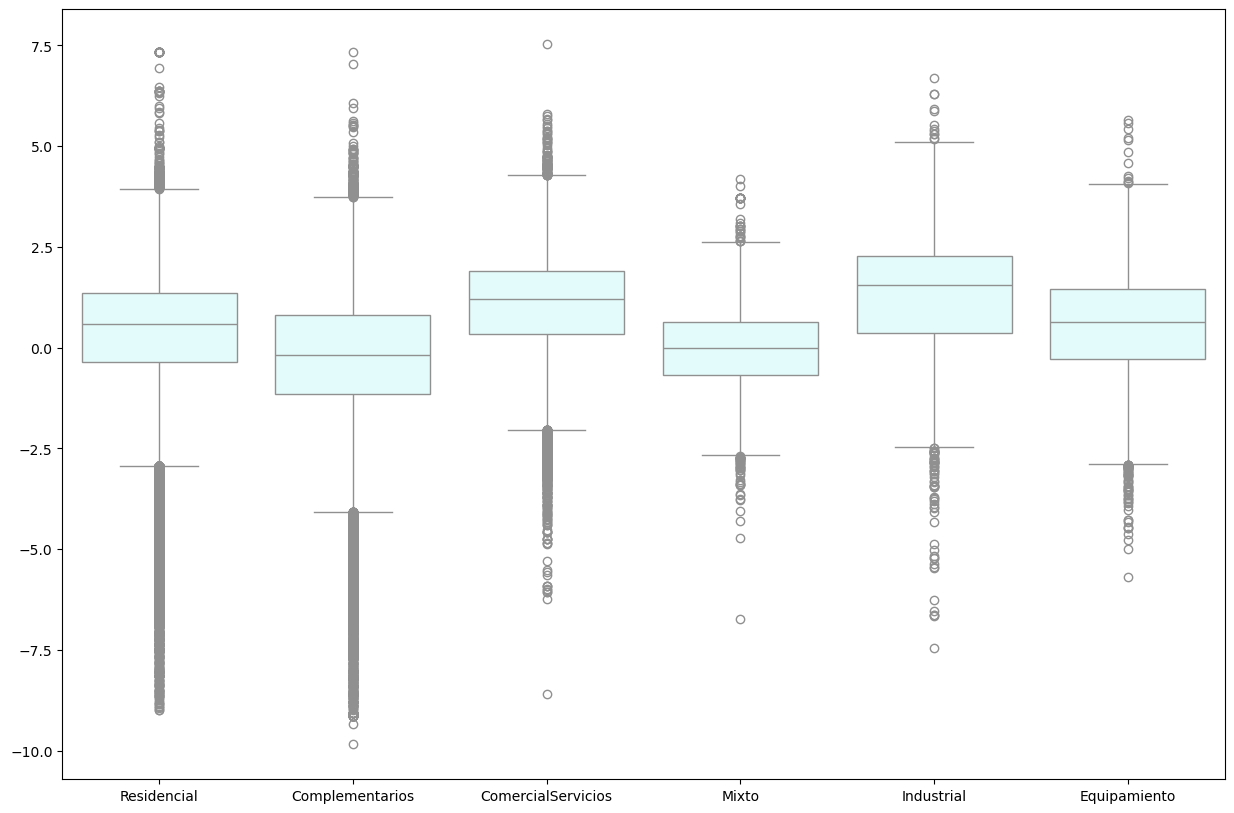

In [57]:
fig,ax=plt.subplots(figsize=(15,10))

sns.boxplot(x=np.array(landuse_temp_gdf.clasificacion_uso_suelo), 
            y=np.array(landuse_temp_gdf.temp_anomal_weighted),
            color='lightcyan',
            ax=ax)

### __Preparation for correlation analysis:__ Add Built area (Google Buildings)

In [46]:
# Isolate hexs
hex_gdf = exploration_gdf_1[['hex_id', 'geometry']].copy()

# Split buildings using the hexs
buildings_split = gpd.overlay(buildings_gdf, hex_gdf, how='intersection')

# Calculate cut area of each building
if buildings_split.crs != projected_crs:
    buildings_split.to_crs(projected_crs,inplace=True)
    print(f"Changed buildings_split crs to {projected_crs}.")    
buildings_split['built_area'] = buildings_split.geometry.area

# Sum built area by hex
hex_building_areas = buildings_split.groupby('hex_id')['built_area'].sum().reset_index()

# Join with geom
hex_gdf = hex_gdf.merge(hex_building_areas, on='hex_id', how='left')
hex_gdf['built_area'] = hex_gdf['built_area'].fillna(0)

# Show
print(hex_gdf.built_area.sum())
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

Changed buildings_split crs to EPSG:32613.
203470241.08113125
EPSG:4326
(69460, 3)


,hex_id,geometry,built_area
0,8a498c972107fff,"POLYGON ((-103.24815 20.64281, -103.2475 20.64...",86.719022
1,8a498c9467a7fff,"POLYGON ((-103.28308 20.67882, -103.28243 20.6...",6131.984191


In [47]:
# Add buildings to exploration_gdf
exploration_gdf_4 = pd.merge(exploration_gdf_3,hex_gdf[['hex_id','built_area']],on='hex_id')

# Built area - Calculate anomaly (differential between mean in each hex and city mean)
#mean_city_builtarea = exploration_gdf_3.built_area.mean()
#print(f"Mean built_area in {city}: {round(mean_city_builtarea,0)} m2.")
#exploration_gdf_3['built_area_anomaly'] = exploration_gdf_3['built_area'] - mean_city_builtarea

# Show
print(exploration_gdf_4.shape)
exploration_gdf_4.head(2)

(69460, 5)


,hex_id,ndvi_mean,temperature_anomaly,ndmi_diff,built_area
0,8a498c972107fff,0.296458,3.285456,0.369276,86.719022
1,8a498c9467a7fff,0.126603,0.103830,0.041648,6131.984191


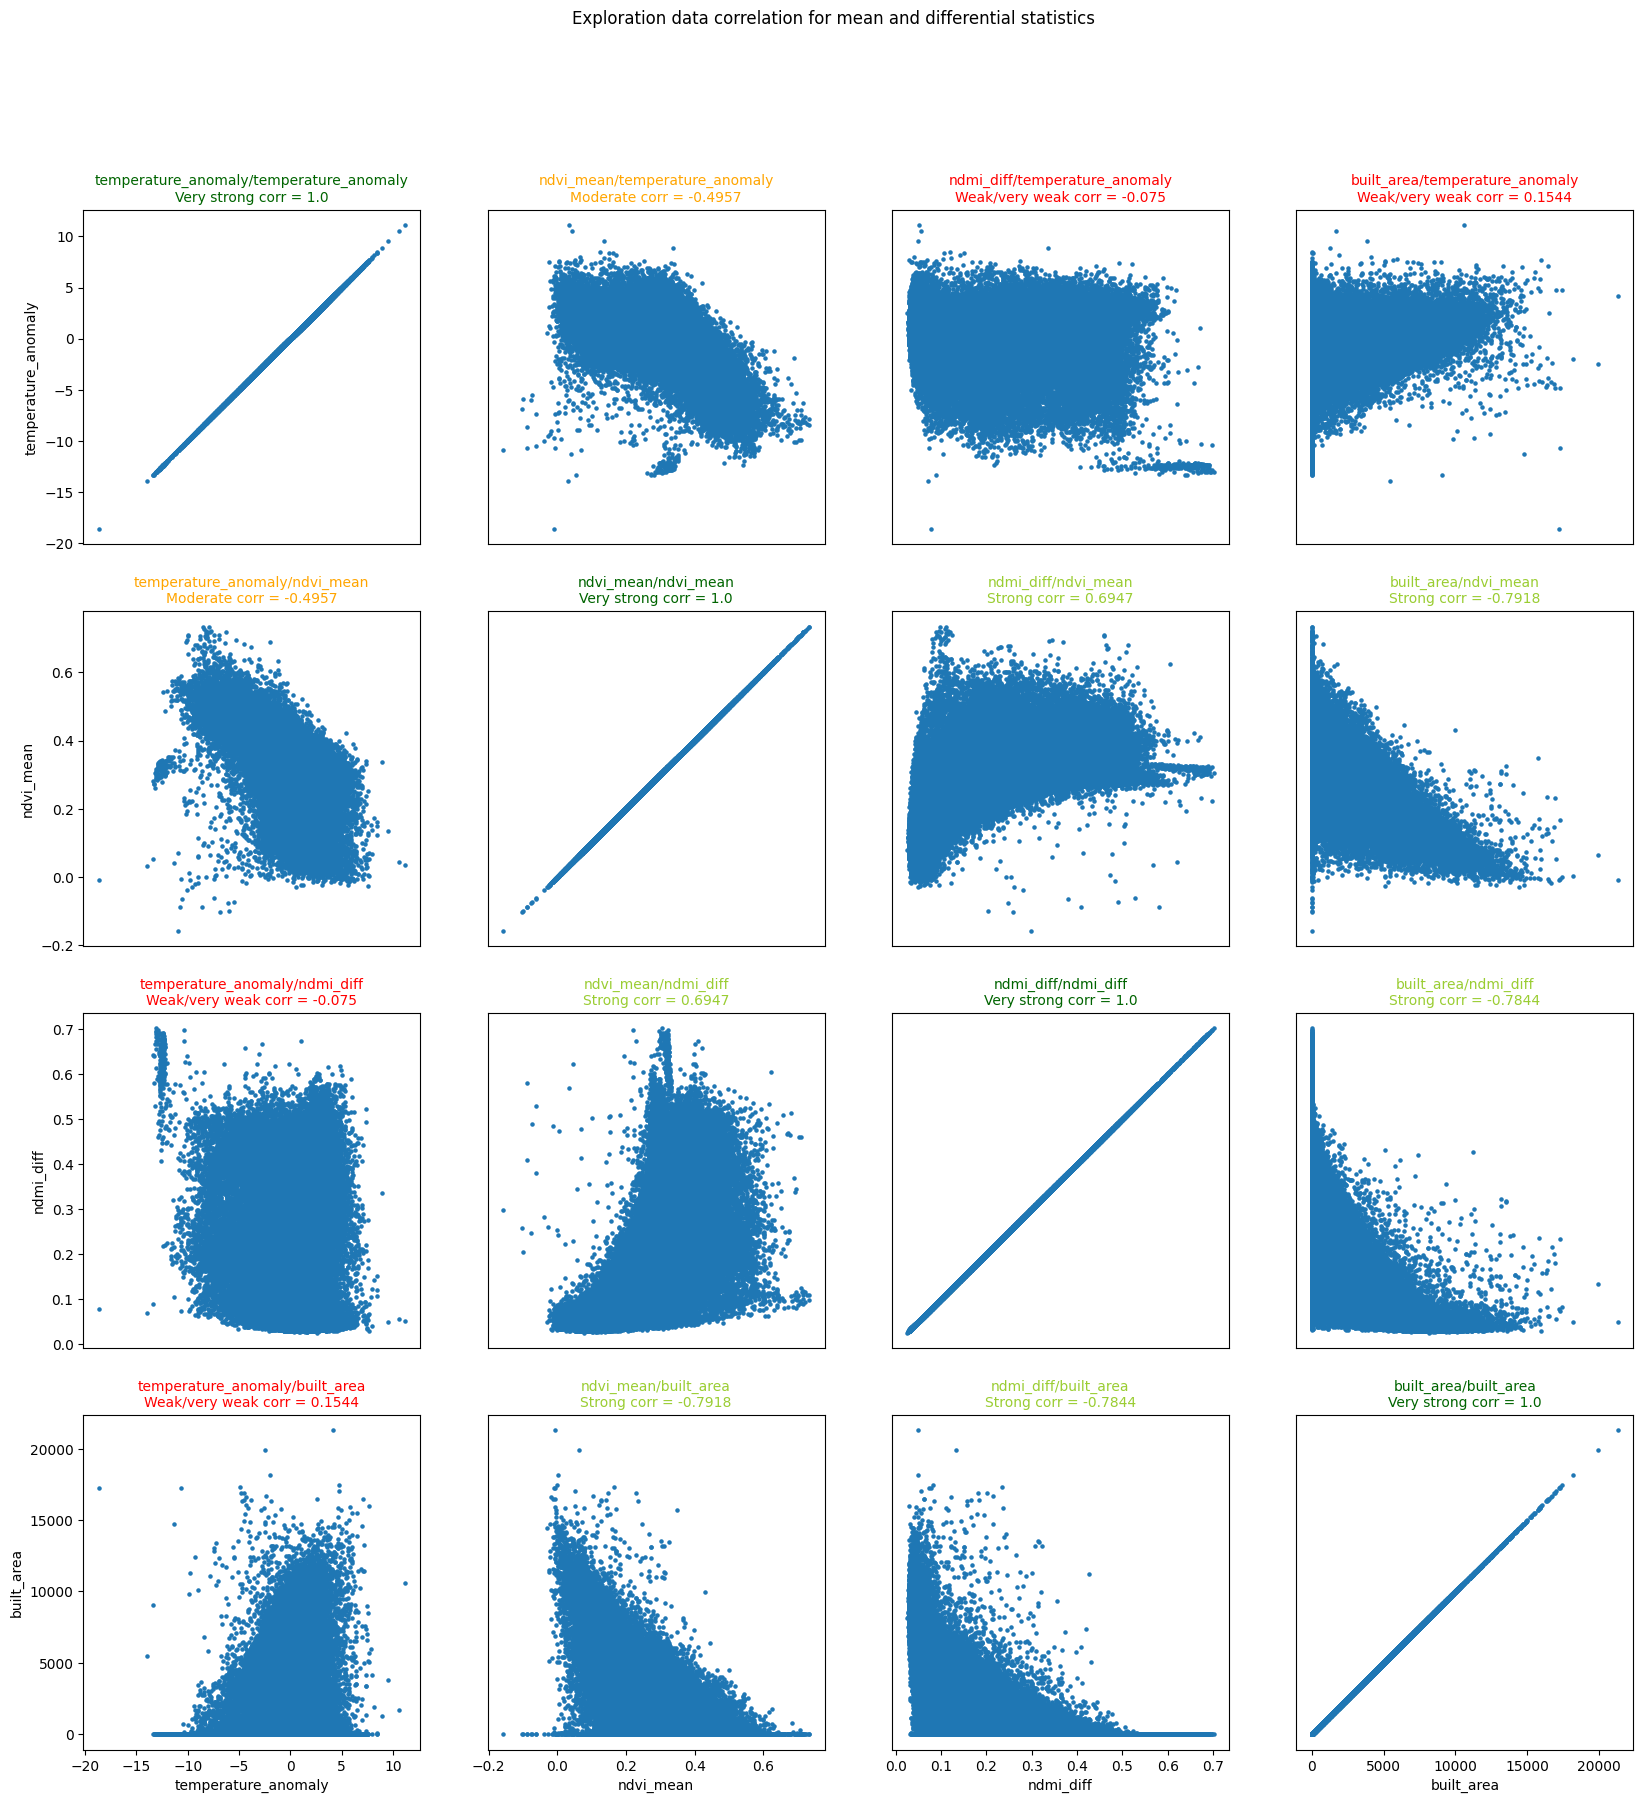

In [48]:
data_gdf = exploration_gdf_4.copy()

# Adjust summary cols (Marg data available for res 8 and 9 only)
if (res==8) or (res==9):
    summary_cols = ['temperature_anomaly','ndvi_mean','ndmi_diff','imn_2020','built_area']
elif res == 10:
    summary_cols = ['temperature_anomaly','ndvi_mean','ndmi_diff','built_area']
    
# Subplots grid with n by n combinations (6 data, 6x6)
fig, axs = plt.subplots(len(summary_cols), len(summary_cols), figsize=(20,20))
fig.suptitle('Exploration data correlation for mean and differential statistics')

# For each col combination
for i in range(len(summary_cols)):

    # For each row
    for j in range(len(summary_cols)):
        
        #Plot scatter
        axs[i,j].scatter(data_gdf[summary_cols[j]], data_gdf[summary_cols[i]], s=5)

        #Correlation
        corr, pval = stats.pearsonr(data_gdf[summary_cols[j]],data_gdf[summary_cols[i]])
        
        # Correlation categories
        abs_corr = abs(corr)
        if abs_corr > 0.80:
            corr_cat = 'Very strong'
            color='darkgreen'
        elif (abs_corr<0.80) and (abs_corr>0.60):
            corr_cat = 'Strong'
            color = 'yellowgreen'
        elif (abs_corr<0.60) and (abs_corr>0.40):
            corr_cat = 'Moderate'
            color = 'orange'
        else:
            corr_cat = 'Weak/very weak'
            color = 'red'

        # Set title with correlation categories and corr data
        axs[i,j].set_title(f"""{summary_cols[j].replace('_count','')}/{summary_cols[i].replace('_count','')}
{corr_cat} corr = {round(corr, 4)}""",fontsize=10,color=color)

        # Format - Turn off tick marks
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)

        # Format - Turn on last row/col tick marks and set used col label
        if i == len(summary_cols) - 1:
            axs[i,j].get_xaxis().set_visible(True)
            axs[i,j].set_xlabel(summary_cols[j])

        if j == 0:
            axs[i,j].get_yaxis().set_visible(True)
            axs[i,j].set_ylabel(summary_cols[i])

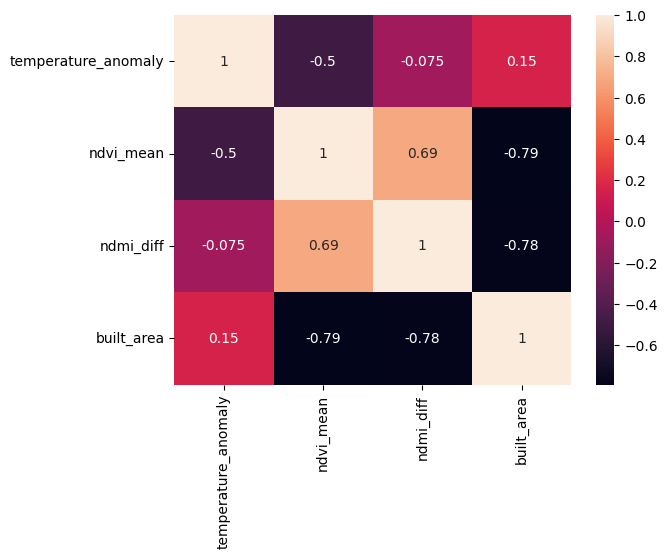

In [49]:
# Isolate data of interest
data_gdf_iso = data_gdf[summary_cols].copy()
# Create correlation heatmap
sns.heatmap(data_gdf_iso.corr(), annot =True, annot_kws={"fontsize":10} )
# Seaborn plot format
sns.set(rc = {'figure.figsize':(5,5)})
# Show
plt.show()